In [ ]:
# assign directory
import git
from pathlib import Path
import os
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
# from transform import *
from transform_audio import *
# from plotting import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))

DATA = "ravdess"
PITCH_NORMALIZED = False
TRIMMED = False
SUFFIX = ''
if PITCH_NORMALIZED:
    SUFFIX += '-pitch-normalized'
if TRIMMED:
    SUFFIX += '-trimmed'


data_dir  = os.path.join(ROOT_DIR, 'raw-data', DATA, f'full-{DATA}-audio-processed{SUFFIX}')
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

In [34]:
max_n = max(map(lambda p: len(wavfile.read(p)[1]), file_list))
max_n

131584

In [35]:
transform_list(fft_file, file_list, file_names, n=max_n)

Computing and exporting coefficients:   0%|          | 0/1440 [00:00<?, ?it/s]

# Fourier Representation

In [36]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa

In [37]:
ravdess_df = pd.read_csv(os.path.join(ROOT_DIR, "raw-data", "ravdess", 'full-ravdess.csv'))

In [38]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

rate, signal1 = wavfile.read(file_list[test_file_idx])
signal2, rate_l = librosa.load(file_list[test_file_idx], sr=None)

Unnamed: 0                                     42
modality                               audio-only
channel                                    speech
emotion                                   neutral
intensity                                  normal
statement            Kids are talking by the door
repetition                                      2
actor                                          19
sex                                          male
filename                 03-01-01-01-01-02-19.wav
length (s)                                  1.344
rate (Hz)                                   48000
amplitudes    [1797 1430  511 ... 6208 5840 5473]
Name: 42, dtype: object


In [39]:
print(rate == rate_l)
print(signal1 / signal2)
# just scaled down by 2**15 (normalized by maximumum signal)
signal = signal2

True
[32768. 32768. 32768. ... 32768. 32768. 32768.]


In [40]:
fft_signal = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), 1/rate)

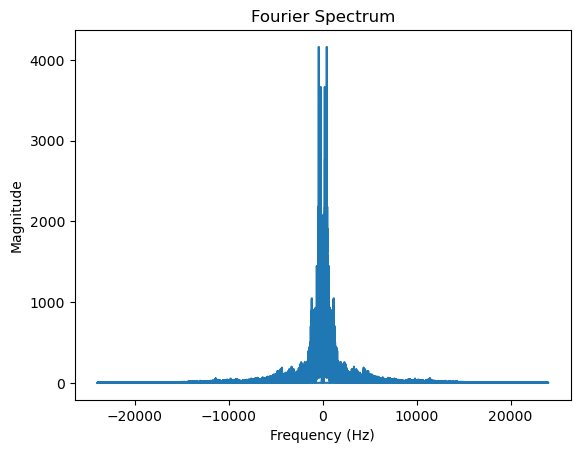

In [41]:
plt.plot(frequencies, np.abs(fft_signal))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Spectrum')
plt.show()

In [42]:
negative_idx = len(frequencies) // 2 # first half nonnegative, second half negative
assert negative_idx == (frequencies < 0).argmax()
assert (frequencies[1:negative_idx] == -frequencies[negative_idx + 1:][::-1]).all() # exclude one negative due to parity mismatch
positive_signals = fft_signal[1:negative_idx]
negative_signals = fft_signal[negative_idx + 1:][::-1]
assert ((positive_signals + negative_signals).imag == 0).all() # all real
print(positive_signals)
print(negative_signals)

[-6.1394025e+02+136.87195j     4.1794995e+02-281.88205j
 -2.2867343e+02+270.8028j     ... -9.5085466e-01  -0.9225661j
 -1.9440754e-01  -0.66254264j -1.5191406e+00  -0.30826655j]
[-6.1394025e+02-136.87195j     4.1794995e+02+281.88205j
 -2.2867343e+02-270.8028j     ... -9.5085466e-01  +0.9225661j
 -1.9440754e-01  +0.66254264j -1.5191406e+00  +0.30826655j]


In [43]:
def fft_file(filename, visualize=False, title='Fourier Spectrum'):
    rate, signal = librosa.load(os.path.join(data_dir, filename), sr=None)
    fft_signal = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/rate)

    if visualize:
        plt.plot(frequencies, np.abs(fft_signal))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(title)
        plt.show()
    
    return fft_signal, frequencies

## Frequency band grouping

In [29]:
transform_dir = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'ravdess-transforms')
coefs_npz_path = os.path.join(transform_dir, 'fft_coefs.npz')

In [30]:
bands = freq_band_groupings(
    coefs_npz_path=coefs_npz_path,
    ks_threshold=0.05,
)

In [31]:
bands

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 8),
 (8, 16),
 (16, 32),
 (32, 48),
 (48, 64),
 (64, 96),
 (96, 128),
 (128, 257),
 (257, 385),
 (385, 449),
 (449, 514),
 (514, 1028),
 (1028, 1542),
 (1542, 2056),
 (2056, 4112),
 (4112, 5140),
 (5140, 6168),
 (6168, 8224),
 (8224, 16448),
 (16448, 32896),
 (32896, 37008),
 (37008, 41120),
 (41120, 45232),
 (45232, 49344),
 (49344, 57568),
 (57568, 65792)]

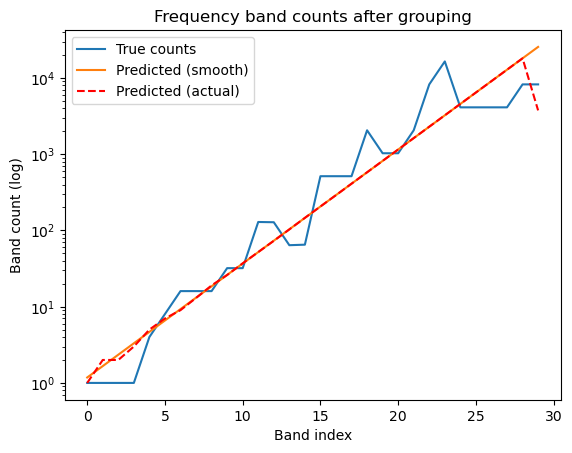

[(0, 1),
 (1, 3),
 (3, 5),
 (5, 8),
 (8, 13),
 (13, 20),
 (20, 29),
 (29, 42),
 (42, 61),
 (61, 87),
 (87, 124),
 (124, 176),
 (176, 249),
 (249, 352),
 (352, 498),
 (498, 704),
 (704, 994),
 (994, 1404),
 (1404, 1982),
 (1982, 2798),
 (2798, 3949),
 (3949, 5573),
 (5573, 7864),
 (7864, 11096),
 (11096, 15656),
 (15656, 22090),
 (22090, 31167),
 (31167, 43974),
 (43974, 62042),
 (62042, 65792)]

In [32]:
geometric_count_bands(bands, visualize=True)

$$\log(g_i) = \theta_0 + \theta_1 i \\
g_i = e^{\theta_0} e^{\theta_1 i} = \alpha \cdot \beta^i \\
\alpha = e^{\theta_0}, \ \beta = e^{\theta_1}$$